# Determinisitic CNN

In [1]:
# imports
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from PIL import Image

In [2]:
# Paths to data
DATA_DIR = "C:/isic/"
DATASET_DIR = DATA_DIR + "datasets/"
IMAGE_DIR = DATA_DIR + "images/"
METADATA_DIR = DATA_DIR + "metadata/"
MODELS_DIR = DATA_DIR + "models/"

In [4]:
# Function to parse a single TFRecord
# The creation of this TFRecord format is specified in notebook 2

def parse_tfrecord_fn(sample):
    feature_description = {
        "image": tf.io.FixedLenFeature((224, 224, 3), tf.float32),
        "label": tf.io.FixedLenFeature((1,), tf.int64),
    }
    sample = tf.io.parse_single_example(sample, feature_description)
    
    return sample["image"], sample["label"]

In [5]:
# Load balanced dataset
isic_bal_tf = DATASET_DIR + "isic_no_duplicates_balanced.tfrecord"
isic_bal_tfrd = tf.data.TFRecordDataset(isic_bal_tf)
isic_bal = isic_bal_tfrd.map(parse_tfrecord_fn) # this is a map dataset, still not loading anything

# some testing
#isic_bal_images = isic_bal.map(lambda image, label: image)
#isic_bal_labels = isic_bal.map(lambda image, label: label)

In [5]:
# Load labels from CSV (faster than parsing each TFRecord)
# irrelevant for the balanced / small dataset
#isic_bal_csv = METADATA_DIR + "isic_trimmed_balanced.csv"
#isic_bal_df = pd.read_csv(isic_bal_csv)
#isic_bal_label_from_csv = isic_bal_df["target"].to_numpy()

In [6]:
# Manually split the dataset into training and validation
dataset_size = 1162  # number of images in the dataset - we know this from the CSV
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = int(0.1 * dataset_size)  # 10% for validation
# the rest 10% will be for testing

train_dataset = isic_bal.take(train_size)
remaining = isic_bal.skip(train_size) # the remaining 20%

val_dataset = remaining.take(val_size) # first 10% of the remaining data is for validation
test_dataset = remaining.skip(val_size) # the rest 10% is for testing

In [8]:
# Needs to access the data sequentially, just to confirm that the split is correct
# List loads the data into memory, so not suitable for large datasets.
debug = True
if debug:
    debug_full_size = len(list(isic_bal))
    debug_train_size = len(list(train_dataset))
    debug_val_size = len(list(val_dataset))
    debug_test_size = len(list(test_dataset))
    print(f"Size of the dataset: {debug_full_size} - 100%")
    print(f"Size of the training set: {debug_train_size} - {debug_train_size / debug_full_size * 100:.2f}%")
    print(f"Size of the validation set: {debug_val_size} - {debug_val_size / debug_full_size * 100:.2f}%")
    print(f"Size of the test set: {debug_test_size} - {debug_test_size / debug_full_size * 100:.2f}%")

Size of the dataset: 1162 - 100%
Size of the training set: 929 - 79.95%
Size of the validation set: 116 - 9.98%
Size of the test set: 117 - 10.07%


In [9]:
# Shuffle and batch the train and validation datasets
batch_size = 32 # split images into batches of 32

# batch, shuffle and prefetch to the training set
train_batched = (
    train_dataset.shuffle(
        buffer_size=1000, seed=111
    ) 
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# batch and prefetch to the validation set
val_batched = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
# This is a very simple CNN model, for demonstration purposes
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(224, 224, 3) # match shape of our images
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(
            1, activation="sigmoid"
        ),  # Binary classification, so use sigmoid activation with single output
    ]
)

In [11]:
# Note number of parameters
# Total params: 11,132,033
# Trainable params: 11,132,033
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [12]:
# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
# Testing callbacks to train on large number of epochs and save the best model
# Results are inconclusive, but functions are kept for future reference

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

# Model checkpoint callback
save_best = tf.keras.callbacks.ModelCheckpoint(
    MODELS_DIR + "2_CNN_isic_balanced_best.h5", monitor="val_accuracy", save_best_only=True
)

# Training Callbacks
callbacks = [early_stopping, save_best]

In [13]:
# Train the model
training = model.fit(
    train_batched,
    epochs=20, # was 100+ with callbacks, but no improvements
    validation_data=val_batched,
    #callbacks=callbacks, # uncomment to use callbacks
)

Epoch 1/20
30/30 [==============================] - 11s 140ms/step - loss: 1.3569 - accuracy: 0.5447 - val_loss: 1.1611 - val_accuracy: 0.5431
Epoch 2/20
30/30 [==============================] - 3s 87ms/step - loss: 0.7475 - accuracy: 0.5145 - val_loss: 0.6912 - val_accuracy: 0.4828
Epoch 3/20
30/30 [==============================] - 3s 88ms/step - loss: 0.6949 - accuracy: 0.5597 - val_loss: 0.6804 - val_accuracy: 0.5948
Epoch 4/20
30/30 [==============================] - 3s 86ms/step - loss: 0.7032 - accuracy: 0.5554 - val_loss: 0.6922 - val_accuracy: 0.4655
Epoch 5/20
30/30 [==============================] - 3s 86ms/step - loss: 0.6890 - accuracy: 0.5565 - val_loss: 0.7384 - val_accuracy: 0.4914
Epoch 6/20
30/30 [==============================] - 3s 86ms/step - loss: 0.6721 - accuracy: 0.5490 - val_loss: 0.7585 - val_accuracy: 0.5000
Epoch 7/20
30/30 [==============================] - 3s 86ms/step - loss: 0.6806 - accuracy: 0.5931 - val_loss: 0.7037 - val_accuracy: 0.4741
Epoch 8/20


In [14]:
# Save the model and history for reference
model.save(MODELS_DIR + "3_CNN_balanced.h5")
np.save(MODELS_DIR + "3_CNN_balanced_history.npy", training.history)

In [ ]:
# load the model and history if not retraining
# model = tf.keras.models.load_model(MODELS_DIR + "3_CNN_balanced.h5")
# history = np.load(MODELS_DIR + "3_CNN_balanced_history.npy", allow_pickle=True).item()

In [15]:
# adapt if loading from history
history = training.history

In [23]:
# analyze the training and validation results
print("Final training accuracy: ", history["accuracy"][-1])
print("Final training loss: ", history["loss"][-1])

print("Final validation accuracy: ", history["val_accuracy"][-1])
print("Final validation loss: ", history["val_loss"][-1])

Final training accuracy:  0.6942949295043945
Final training loss:  0.5885522961616516
Final validation accuracy:  0.6120689511299133
Final validation loss:  1.4163813591003418


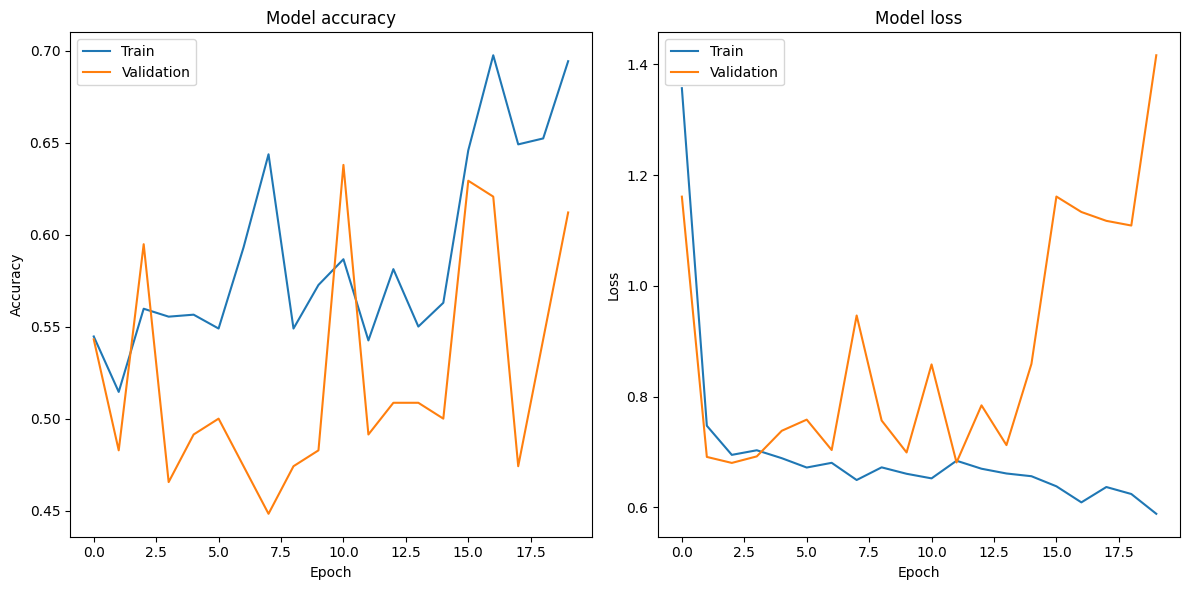

In [21]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# Display the plots
plt.tight_layout()
plt.show()

## Testing on the test set

In [25]:
test_dataset_batched = test_dataset.batch(batch_size)
test_loss, test_accuracy = model.evaluate(test_dataset_batched, verbose=2)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

4/4 - 1s - loss: 0.8736 - accuracy: 0.7179 - 1s/epoch - 351ms/step
Test accuracy: 0.7179487347602844
Test loss: 0.8735827803611755


## Determinisic nature of a CNN

In [38]:
# Extract a single batch from the test set
for image, label in test_dataset.take(1):
    print("Original shape:", image.shape)
    # Add an extra dimension to represent the batch size
    image_batch = tf.expand_dims(image, axis=0)
    print("New shape:", image_batch.shape)

Original shape: (224, 224, 3)
New shape: (1, 224, 224, 3)


In [37]:
# Make a prediction on the sample image
prediction1 = model.predict(image_batch)
prediction1

1/1 [==============================] - 0s 69ms/step


array([[0.5536709]], dtype=float32)

In [39]:
# Let's make a new prediction with the same image
prediction2 = model.predict(image_batch)
prediction2

1/1 [==============================] - 0s 18ms/step


array([[0.5536709]], dtype=float32)

In [40]:
# Check if the predictions are the same
predictions = np.array_equal(prediction1, prediction2)
print(f"Is prediction1 equal to prediction2? {predictions}")

Is prediction1 equal to prediction2? True


The model will always return the exact same prediction for a sample image after training, therefore being deterministic.